In [1]:
%load_ext autoreload
%autoreload 2

from src.models.wifi_model import WifiModel
from src.data.datasets import FloorDataset
from src.utils import object_to_markdown, get_study
from src.plotting import *


from IPython.display import display,Image

import seaborn as sns
import matplotlib.pyplot as plt
import torch

site_id = "5a0546857ecc773753327266"
floor_id = "B1"

floor_data = FloorDataset(
        site_id, 
        floor_id, 
        wifi_threshold=200, 
        sampling_interval=100, 
        include_wifi=True, 
        include_beacon=False,        
        validation_percent=None,
        test_percent=0.15
        )

floor_data_full = FloorDataset(
        site_id, 
        floor_id, 
        wifi_threshold=200, 
        sampling_interval=100, 
        include_wifi=True, 
        include_beacon=False,        
        )

floor_image = floor_data.image
floor_height = floor_data.info["map_info"]["height"]
floor_width = floor_data.info["map_info"]["width"]
sns.set(style="whitegrid")

# Wifi Model

In a vacuum with no obstacles (i.e. doors, walls, humans, air molecules, etc.) a cellphone will from a WiFi router receive signal intensities, which follows the Inverse-square law (see [wiki page](https://en.wikipedia.org/wiki/Inverse-square_law)),
$$I =\frac{I_0}{r^2},$$
where $I$ is signal intensity, $I_0$ is the intensity measured at $r=1$ and $r$ is the distance between the source and the receiver.
Since the signal intensity rssi is measured on a log scale, we transform the Inverse-square law, 
$$ \log (I) = \log {I_0}-2\log{r}.$$

Assuming the measured signal intensity has underlying Gaussian noise we arrive at the following distribution for the rssi signal $w_{t,k}$ (at time $t$ and from WiFi router $k$),

\begin{equation}\label{eq1}
    w_{t,k} \sim  \mathcal{N}(w^0_k- 2\log{||\boldsymbol{x}_t-\boldsymbol{\ell}_k||}, \sigma_{\omega}),
\end{equation}

where $w^0_k$ is the measured rssi signal 1 unit away from $\boldsymbol{\ell}_k$ and $||\boldsymbol{x}_t -\boldsymbol{\ell}_k||$ is the distance between the position $\boldsymbol{x}_t$ and WiFi router location $\boldsymbol{\ell}_k$. 

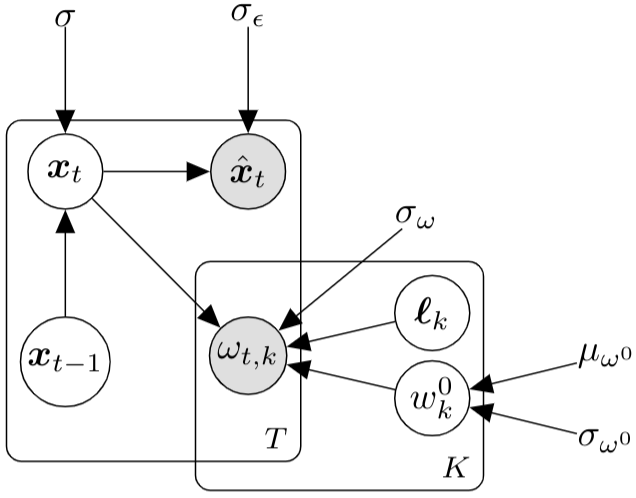

In [28]:
Image(filename='wifi_model.png', width = 300) 

We have implemented the model in `src/models/wifi_model.py` as a method of the `WifiModel` class which also holds various model attributes and the variational parameters. 
The extended PGM and corresponding source code of the generative model can be seen below:

In [29]:
display(object_to_markdown(WifiModel.model))

```python
def model(
    self,
    mini_batch_index,
    mini_batch_length,
    mini_batch_time,
    mini_batch_position,
    mini_batch_position_mask,
    mini_batch_wifi,
    mini_batch_wifi_mask,
    annealing_factor=1.0,
):

    pyro.module("wifi_model", self)

    T_max = mini_batch_time.shape[-1]
    K = self.K

    relaxed_floor_dist = dist.Normal(
        self.floor_uniform.mean, self.floor_uniform.stddev
    ).to_event(1)

    sigma = torch.tensor(self.prior_params["sigma"], device=device)
    sigma_eps = torch.tensor(self.prior_params["sigma_eps"], device=device)
    mu_omega_0 = torch.tensor(self.prior_params["mu_omega_0"], device=device)
    sigma_omega_0 = torch.tensor(self.prior_params["sigma_omega_0"], device=device)
    sigma_omega = torch.tensor(self.prior_params["sigma_omega"], device=device)

    with poutine.scale(None, annealing_factor):

        with pyro.plate("mini_batch", len(mini_batch_index)):

            x_0 = sample("x_0", relaxed_floor_dist)
            x = torch.zeros(
                x_0.shape[:-1] + (T_max,) + x_0.shape[-1:],  # Batch dims, time, x/y
                dtype=mini_batch_position.dtype,
                device=device,
            )
            x[..., 0, :] = x_0

            for t in pyro.markov(range(1, T_max)):
                x[..., t, :] = sample(
                    f"x_{t}",
                    dist.Normal(x[..., t - 1, :], sigma)
                    .to_event(1)
                    .mask(t < mini_batch_length),
                )

    with pyro.plate("x_observed", mini_batch_position_mask.sum()):
        sample(
            "x_hat",
            dist.Normal(x[..., mini_batch_position_mask, :], sigma_eps).to_event(1),
            obs=mini_batch_position[mini_batch_position_mask],
        )

    any_wifi_is_observed = mini_batch_wifi_mask.any(dim=-1)

    with plate("wifis", K):

        with poutine.scale(None, annealing_factor):
            omega_0 = sample("omega_0", dist.Normal(mu_omega_0, sigma_omega_0))
            wifi_location = sample("wifi_location", relaxed_floor_dist)

        distance = torch.cdist(x[..., any_wifi_is_observed, :], wifi_location)
        with plate("wifi_is_observed", any_wifi_is_observed.sum()):
            signal_strength = omega_0 - 2 * torch.log(distance)
            omega = sample(
                "omega",
                dist.Normal(signal_strength, sigma_omega).mask(
                    mini_batch_wifi_mask[any_wifi_is_observed]
                ),
                obs=mini_batch_wifi[any_wifi_is_observed],
            )

    return x, wifi_location
```

We have patitioned the data into a test and training set. The test set consists of $15\%$ of the 109 traces, for which we removed the observed positions. This allows us to investigate how well the model is able to infer the latent position, only given sensor readings. Below, we extract some of the traces from the test set for comparison later.

In [30]:
train_indices = (~floor_data.test_mask & ~floor_data.validation_mask).nonzero().flatten()
test_indices = floor_data.test_mask.nonzero().flatten()


mini_batch_train = floor_data_full[train_indices[[2, 6, 9, 16, 23, 40, 67]]]
mini_batch_test = floor_data_full[test_indices[[3,6,9,10]]]

In [31]:
torch.manual_seed(123)
wifi_model = WifiModel(floor_data)

In [32]:
x, wifi_location = wifi_model.model(*mini_batch_train)

Similarily to the initial position, the prior of the wifi router location is a relaxed floor distribution, i.e. weak normal distribution close to a uniform distribtion on the floor $U([0, width_{floor}], [0,height_{floor}])$. 

This is used in order to match the domain of the guide function. Below is the model, with simple random walks of the trace data and weakly normal distribtruion of the wifi router locations. 

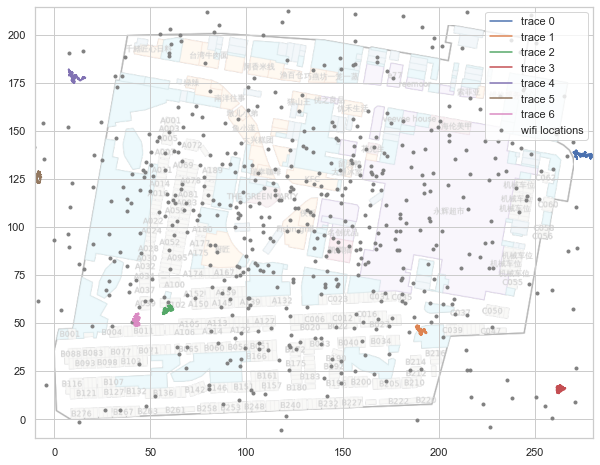

In [33]:
plt.figure(figsize=(10,10))
plt.scatter(*wifi_location.T, marker=".", color="grey", label="wifi locations")
plt.plot(*x.T, label=[f"trace {i}" for i in range(x.shape[0])])
plt.imshow(floor_image, extent=(0, floor_width, 0, floor_height), alpha = 0.3)
plt.xlim(-10,floor_width+10)
plt.ylim(-10,floor_height+10)

plt.legend()
plt.show()

As for the inital model, we used amotized variational inference for inference on $\boldsymbol x$, and we used a mean field approximation for the other variational distributions eg. wifi locations and signal strengths. The extended guide function is seen below:

In [34]:
display(object_to_markdown(WifiModel.guide))

```python
def guide(
    self,
    mini_batch_index,
    mini_batch_length,
    mini_batch_time,
    mini_batch_position,
    mini_batch_position_mask,
    mini_batch_wifi,
    mini_batch_wifi_mask,
    annealing_factor=1.0,
):

    pyro.module("wifi_model", self)

    T_max = mini_batch_time.shape[-1]
    K = self.K

    location = torch.zeros((len(mini_batch_index), T_max, 2), device=device)
    scale = torch.zeros((len(mini_batch_index),), device=device)

    for i, (index, length) in enumerate(zip(mini_batch_index, mini_batch_length)):
        l, s = self.trace_guides[index](mini_batch_time[i, :length].unsqueeze(1))
        location[i, :length, :] = l
        scale[i] = s

    with poutine.scale(None, annealing_factor):

        with pyro.plate("mini_batch", len(mini_batch_index)):

            for t in pyro.markov(range(0, T_max)):
                sample(
                    f"x_{t}",
                    dist.Normal(location[:, t, :], scale.view(-1, 1))
                    .to_event(1)
                    .mask(t < mini_batch_length),
                )

        with plate("wifis", K):
            sample("omega_0", dist.Normal(self.mu_q, self.log_sigma_q.exp()))
            sample(
                "wifi_location",
                dist.Normal(
                    self.wifi_location_q, self.wifi_location_log_sigma_q.exp()
                ).to_event(1),
            )

    return location, scale
```

## Model Training
Again, we used hyperparameter search to try and fit our models. The best model can be seen below

In [35]:
checkpoint = torch.load("../checkpoints/wifi_hparam_030.pt", map_location="cpu")
wifi_model.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

We can investigate the training loss over the course of training the model

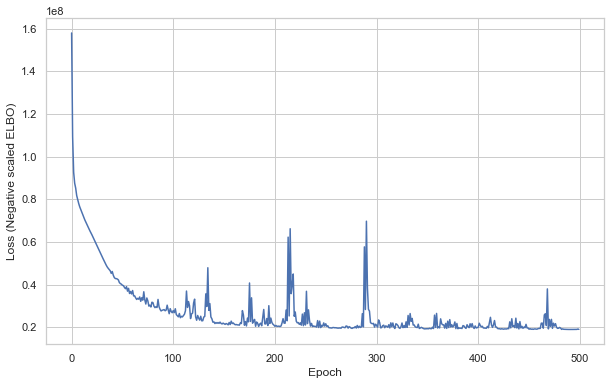

In [36]:
plt.figure(figsize=(10,6))
plt.plot(checkpoint["loss_history"])
plt.xlabel("Epoch")
plt.ylabel("Loss (Negative scaled ELBO)")
plt.show()

We see that while the model does converge somewhat, the training is a bit unstable. Below we investigate the fitted model

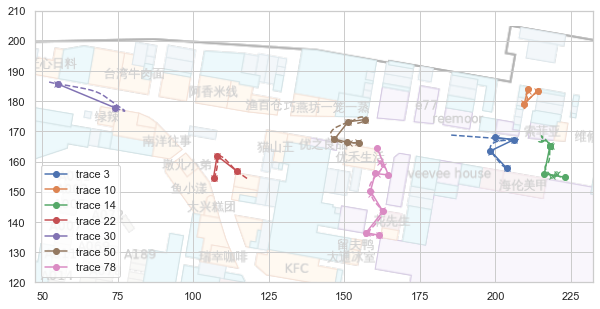

In [37]:
plt.figure(figsize=(10, 5))
plt.imshow(floor_image, extent=(0, floor_width, 0, floor_height), alpha=0.3)
plot_traces(wifi_model, mini_batch_train)
plt.axis("equal");
plt.xlim(50, 230)
plt.ylim((120, 210))
plt.legend()

We see that the traces for the data with included waypoints does fit to the path of the traces. More interesting, however, is whether the model can predict the traces where we removed the waypoint data:

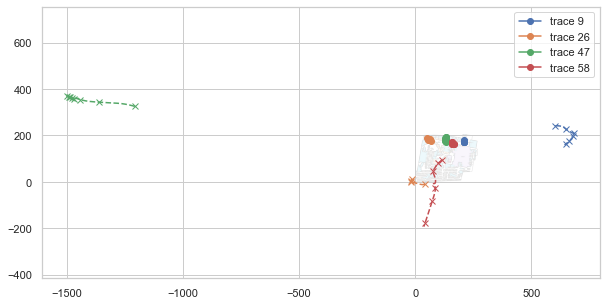

In [38]:
plt.figure(figsize=(10, 5))
plt.imshow(floor_image, extent=(0, floor_width, 0, floor_height), alpha=0.3)
plot_traces(wifi_model, mini_batch_test)
plt.axis("equal");
plt.ylim((140, 200))

plt.legend()
plt.show()

As is quite evident from the plot above, the model does not really generalize well to data with unobserved positions. 

The posterior of each wifi location is represented in the guide function to be a normal distribution with diagonal covariance. The wifi location with 2 std. eplises is plotted here, notice that some ot the wifi locations has very low variance while others have very high variance. There does seem to be a slight tendency for the wifi locations to be placed on the edges of the floor, otherwise the estimated expected posterior positions seem almost uniform. 

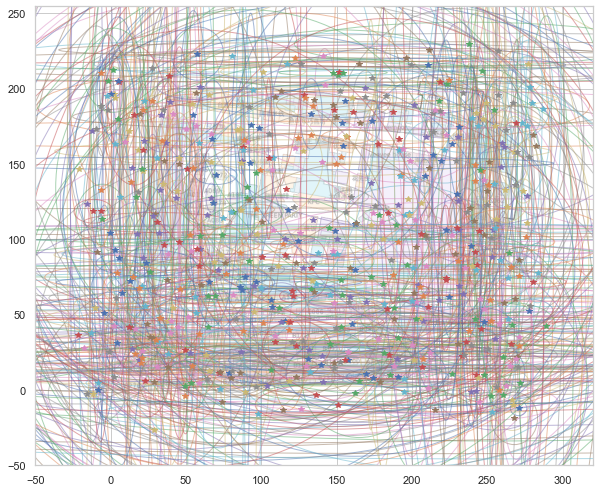

In [39]:
plt.figure(figsize=(10, 10))
plt.imshow(floor_image, extent=(0, floor_width, 0, floor_height), alpha=0.5)
plot_wifi(wifi_model)
plt.xlim(-50, floor_width + 50)
plt.ylim(-50, floor_height + 50)
plt.show()

We can compare these posteriors to the observed wifis plotted in the exploratory notebook. Below, for six different wifis, we plot the observed signal strengths alongside the estimated posterior distribution of the router location.

In [40]:
from src.plotting import get_wifi_strengths

wifi_indices = [0, 1, 2, 3, 4, 5]
wifi_bssids = [floor_data.bssids_[i] for i in wifi_indices]
wifi_strengths = get_wifi_strengths(floor_data, wifi_bssids)

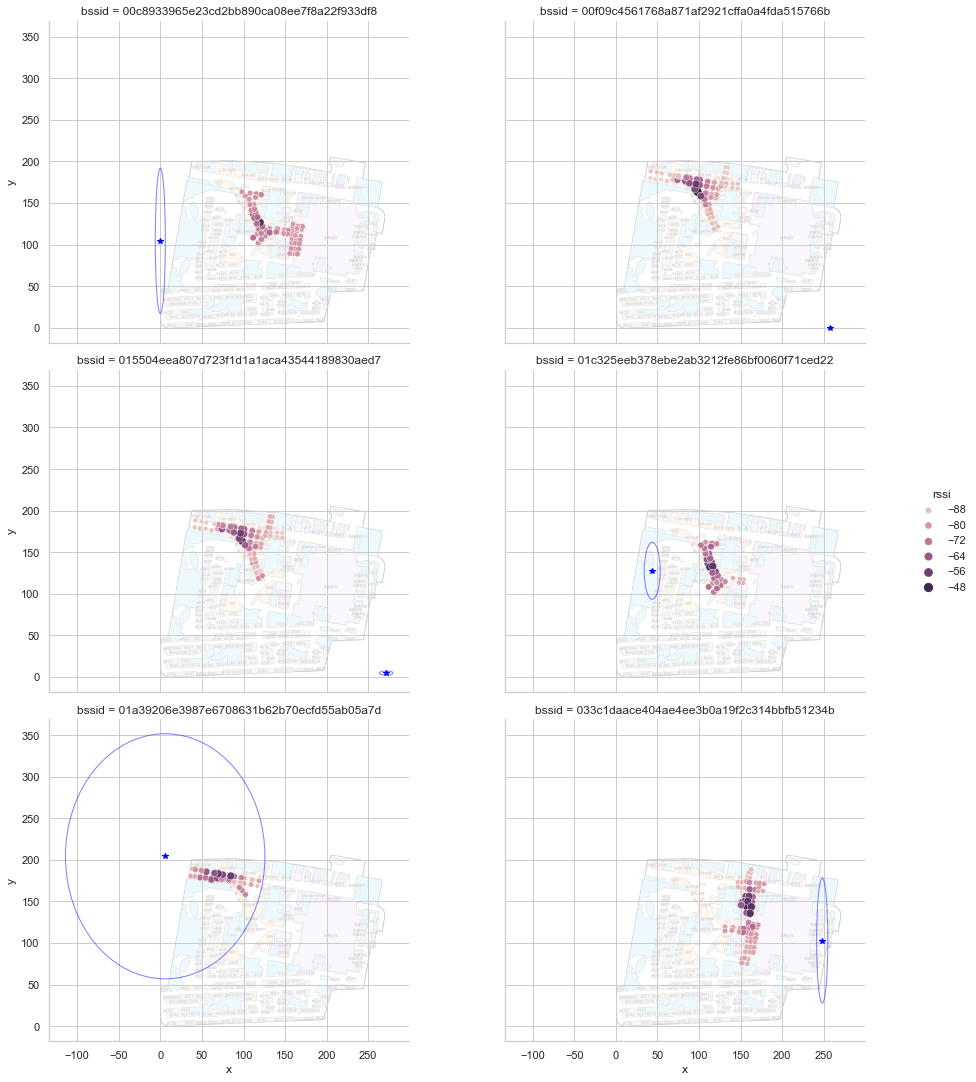

In [41]:
fg = sns.relplot(data=wifi_strengths, x="x", y="y", col="bssid", col_wrap=2, hue="rssi", size='rssi', aspect=floor_width/floor_height)
for bssid, ax in fg.axes_dict.items():
    ax.imshow(floor_data.image, extent=(0, floor_width, 0, floor_height), alpha=0.3)
    plot_wifi(wifi_model, [wifi_bssids.index(bssid)], ax=ax, color="blue")

As can be seen, these positions does not seem that reasonable considering the observed wifi strengths. Ideally, we would want the router position to be right in the middle of the most area with highest rssi, however that is not what we see from our model. We were unfortunately unable to figure out why exactly our model behaves this way. 